# Main functions used in experiments

In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Environment: Windy gridworld
Gives a reward of -1 for each step taken, while the final state is not reached

In [2]:
from windy_gridworld import WindyGridworldEnv
from gridworld import GridworldEnv
# env = WindyGridworldEnv()
# env = GridworldEnv()
# env??
import gym
env = gym.envs.make("FrozenLake-v0")
env.env.__init__(is_slippery=False)

/Users/berend/miniconda3/envs/rl2020/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Policy

### Target policy (choose greedy vs non-greedy)
Greedy policy 

In [3]:
class GreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q):
        self.Q = Q
    
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a greedy policy
        """   
        # for state and action only:
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        if action in max_indices:
            prob = 1/len(max_indices)
        else:
            prob = 0
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """

        best_actions = [i for i, j in enumerate([self.Q[obs][i] for i in range(4)]) 
                   if j == max([self.Q[obs][i] for i in range(4)])] 

        best_action = np.random.choice(best_actions)
        
        return best_action

In [4]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
        
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a epsilon greedy policy
        """

        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        # all probs are equal, give all equal probabilities
        if len(max_indices) == len(action_probs):
            return 1/len(max_indices)
            
        if action in max_indices:
            prob = (1-self.epsilon)/len(max_indices)
        else:
            prob = epsilon / (len(action_probs) - len(max_indices))
        
        return prob
    

    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
         
        best_actions = [i for i, j in enumerate(self.Q[obs])
                   if j == np.max(self.Q[obs])] 

        p = np.random.uniform()
        if p > self.epsilon:
            # choose one of the best actions
            action = np.random.choice(best_actions)
        else:
            action = np.random.randint(0,4)
                
        return action


# Monte Carlo

In [5]:
def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length. 
        state after the termination is not included in the list of states.
    """
    # initialize
    states = []
    actions = []
    rewards = []
    dones = []
    
    # get a starting state
    s = env.reset()
    d = False
    
    # keep looping until done, don's save the terminal state
    while not d:
        states.append(s)
        a = policy.sample_action(s)
        s, r, d, _ = env.step(a)
        
        # save                
        actions.append(a)
        rewards.append(r)
        dones.append(d)
        

    return states, actions, rewards, dones

In [6]:
# check the length of episodes that are generated for eps greedy policy
Q = np.zeros((env.env.nS, env.env.nA))
bp = EpsilonGreedyPolicy(Q, epsilon=0.1)

for episode in range(1):
    trajectory_data = sample_episode(env, bp)
    print(f"length of episode {episode}: {len(trajectory_data[0])}")

length of episode 0: 2


## Importance Sampling


In [97]:
def mc_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, discount_factor=1.0,
                           sampling_function=sample_episode, epsilon=0.05, seed=42, 
                           analyse_states=[(0,2), (0,1), (14,2), (2,1)]):
    """
    Monte Carlo prediction algorithm. Calculates the Q function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        weighted: Boolean flag to use weighted or ordinary importance sampling.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from (state, action) -> value.
    """

    # set the current Q to a large negative value
    Q = np.zeros((env.env.nS, env.env.nA))
    if weighted:
        C = np.zeros((env.env.nS, env.env.nA))
    else:
        returns_count = defaultdict(lambda: defaultdict(float))
    
    episode_lens = []
    
    # set seed
    np.random.seed(seed)
    
    analysis_values = dict((k,[]) for k in analyse_states)
    
    # sample episodes
    for i in tqdm(range(num_episodes), position=0):
        # update behavioral and target policy
        behavior_policy.Q = Q
        target_policy.Q = Q        
    
        # sample episode with new behavioural function
        states, actions, rewards, dones = sampling_function(env, behavior_policy)
        
        # save the episode length
        episode_lens.append(len(states)) 

        G = 0        
        W = 1
        
        # loop backwards over the trajectory
        for i, timestep in enumerate(range(len(states)-1, -1, -1)):
            s = states[timestep]
            r = rewards[timestep]
            a = actions[timestep]
            G = discount_factor * G + r
            
            if weighted:
                # add W to the sum of weights C
                C[s][a] += W
                Q[s][a] += W/C[s][a] * (G - Q[s][a])
            else:
                returns_count[s][a] += 1 
                # use every visit incremental method
                Q[s][a] += 1/returns_count[s][a] * W * (G - Q[s][a])

            W *= (target_policy.get_probs(s, a)) / (behavior_policy.get_probs(s, a))        

            if W == 0:
                break

        # store state values to analyse
        for (s,a) in analyse_states:
#             print(Q[s][a])
            analysis_values[(s,a)].append(Q[s][a])
            
    return Q, episode_lens, analysis_values

## Performance


In [98]:
# Reproducible
seed = 42

# set other parameters
epsilon = 0.2
gamma = 0.99
num_episodes = 5000
Q = np.ones((env.env.nS, env.env.nA)) * 0
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_mc_ordinary, mc_ordinary_epslengths, mc_analysis_ordinary = mc_importance_sampling(env,
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)

print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_mc_weighted, mc_weighted_epslengths, mc_analysis_weighted = mc_importance_sampling(env,
                                                               behavioral_policy, target_policy,
                                                               num_episodes, weighted=True, discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (5000 episodes)


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes)


100%|██████████| 5000/5000 [00:02<00:00, 1820.17it/s]


In [99]:
# check how long an episode takes under the found Q function
mc_greedy_ordinary = GreedyPolicy(Q_mc_ordinary)
mc_greedy_weighted = GreedyPolicy(Q_mc_weighted)

mc_ordinary_episode = sample_episode(env, mc_greedy_ordinary)
mc_weighted_episode = sample_episode(env, mc_greedy_weighted)

print(f"resulting episode length ordinary: {len(mc_ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(mc_weighted_episode[0])}")

resulting episode length ordinary: 6
resulting episode length weighted: 6


In [100]:
# print(np.var(weighted_analysis[(19,3)]))
# print(np.var(ordinary_analysis[(19,3)]))
# Q_mc_weighted[19][3]
print(Q_mc_ordinary)

[[0.81148615 0.94968353 0.92520813 0.89240698]
 [0.92177005 0.         0.52225995 0.72665189]
 [1.03031037 0.96305249 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.84537205 0.96058792 0.         0.91857785]
 [0.         0.         0.         0.        ]
 [0.         0.97908376 0.         0.92282858]
 [0.         0.         0.         0.        ]
 [0.95982983 0.         0.97029505 0.95023227]
 [0.96050051 0.96402332 0.9800738  0.        ]
 [0.97025661 0.98993753 0.         0.9683497 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.47199208 0.99018128 0.96996367]
 [0.8696735  0.9887112  1.         0.9796195 ]
 [0.         0.         0.         0.        ]]


In [78]:
env.reset()


0

### Plotting episode lengths during training

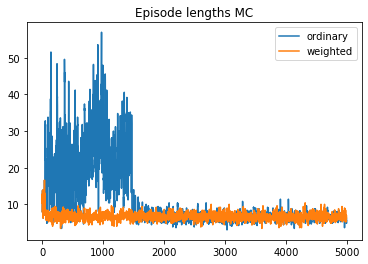

In [79]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 5

plt.plot(running_mean(mc_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(mc_weighted_epslengths, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Episode lengths MC')
# plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

# Temporal Difference

### TO-DO: TD Ordinary Importance Sampling (make it work for gridworld)
Copied from TD_lab. Currently on-policy, needs to be off-policy.

Confused: do we need value functions instead of q-values? Do we even use importance weights in off-policy TD? Are there more off-policy TD methods besides SARSA?

In [80]:
def sarsa_ordinary_importance_sampling(env, behavior_policy, target_policy,
                                       num_episodes, discount_factor=1.0, alpha=0.5,
                                      analyse_states=[(0,0), (3,2), (0,2)]):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    stats = []
    
    Q = np.ones((env.env.nS, env.env.nA)) * 0
    
    for i_episode in tqdm(range(num_episodes), position=0):
        i = 0
        R = 0
        W = 1
        
        behavior_policy.Q = Q
        target_policy.Q = Q
            
        s = env.reset()
        a = behavior_policy.sample_action(s)
        
        while True:
            # Take action
            s_prime, r, final_state, _ = env.step(a)
            
            # Sample action at from next state
            a_prime = behavior_policy.sample_action(s_prime)

            # Update Q 
            Q[s][a] += alpha * W * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])    
            
            # Update weight
            W = (target_policy.get_probs([s_prime],[a_prime]))/(behavior_policy.get_probs([s_prime],[a_prime]))
            
            s = s_prime
            a = a_prime
            
            R += r
            i += 1 
            
            if final_state:
                break
            
        stats.append((i, R))
        
#     Q = Qdefaultdict2array(Q, env.nA, env.nS)
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

### TO-DO: TD Weighted Importance Sampling (same as above but weighted)

In [81]:
## TD weighted importance sampling

In [82]:
import math
def sarsa_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, 
                                       discount_factor=1.0, alpha=0.5, seed=42,
                                 analyse_states=[(0,2), (0,1), (14,2), (2,1)]):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        target policy: A policy which allows us to sample actions with its sample_action method.
        behaviour policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    np.random.seed(seed)
    
    # Keep track of useful statistics
    stats = []
    
#     Q = np.ones((env.nS, env.nA)) * -100
    Q = np.zeros((env.env.nS, env.env.nA))
    C = np.zeros((env.env.nS, env.env.nA))
    
    analysis_values = dict((k,[]) for k in analyse_states)
    
    for i_episode in tqdm(range(num_episodes), position=0):
        i = 0
        R = 0
        W = 1
        
        behavior_policy.Q = Q
        target_policy.Q = Q
            
        s = env.reset()
        a = behavior_policy.sample_action(s)
        
        while True:
            # Take action
            s_prime, r, final_state, _ = env.step(a)
            
            # Sample action at from next state
            a_prime = behavior_policy.sample_action(s_prime)                        
            
            if W == 0:
                break
            
            if weighted:
                # Update weight and C
                C[s][a] = W
                # importance weight is 1 
                Q[s][a] += W/C[s][a] * alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])                
            else:
                Q[s][a] += W * alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])                
            
            W = (target_policy.get_probs(s_prime,a_prime))/(behavior_policy.get_probs(s_prime,a_prime))
    
            behavior_policy.Q[s][a] = Q[s][a]
            target_policy.Q[s][a] = Q[s][a]
            
            s = s_prime
            a = a_prime
            
            R += r
            i += 1 
            
            if final_state:
                break
            
        stats.append((i, R))

        # store state values to analyse
        for (s,a) in analyse_states:
#             print(Q[s][a])
            analysis_values[(s,a)].append(Q[s][a])
    
    episode_lengths, episode_returns = zip(*stats)
    
    return Q, episode_lengths, analysis_values

In [86]:
# Reproducible
seed = 42

# set other parameters
epsilon = 0.2
gamma = 0.99
num_episodes = 5000
Q = np.zeros((env.env.nS, env.env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_sarsa_ordinary, sarsa_ordinary_epslengths, sarsa_analysis_ordinary = sarsa_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,
                                                                         discount_factor=gamma, seed=seed)

Q = np.zeros((env.env.nS, env.env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)


print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_sarsa_weighted, sarsa_weighted_epslengths, sarsa_analysis_weighted = sarsa_importance_sampling(env, 
                                                                        behavioral_policy, target_policy,
                                                                        num_episodes, weighted=True,
                                                                        discount_factor=gamma, seed=seed)


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (5000 episodes)


  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes)


100%|██████████| 5000/5000 [00:02<00:00, 2001.23it/s]


In [87]:
# check how long an episode takes under the found Q function
sarsa_greedy_ordinary = GreedyPolicy(Q_sarsa_ordinary)
sarsa_greedy_weighted = GreedyPolicy(Q_sarsa_weighted)

sarsa_ordinary_episode = sample_episode(env, sarsa_greedy_ordinary)
sarsa_weighted_episode = sample_episode(env, sarsa_greedy_weighted)

print(f"resulting episode length ordinary: {len(sarsa_ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(sarsa_weighted_episode[0])}")

resulting episode length ordinary: 6
resulting episode length weighted: 6


## Experiments

In [88]:
print(sarsa_ordinary_episode)

([0, 1, 2, 6, 10, 14], [2, 2, 1, 1, 1, 2], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [False, False, False, False, False, True])


In [89]:
Q_sarsa_ordinary

array([[0.02286445, 0.011867  , 0.429644  , 0.17633643],
       [0.        , 0.        , 0.68179129, 0.        ],
       [0.        , 0.51914372, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.2461518 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.74400588, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.98996597, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [90]:
Q_sarsa_weighted[14][2]
sarsa_analysis_weighted.keys()

dict_keys([(0, 2), (0, 1), (14, 2), (2, 1)])

In [91]:
sarsa_analysis_weighted[(0,2)]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.014859219529687499,
 0.007429609764843749,
 0.05572207323632811,
 0.13559037820839842,
 0.12165985989931638,
 0.2066360215847168,
 0.23565793472863772,
 0.3056587892317749,
 0.15282939461588746,
 0.23115953819132995,
 0.11557976909566497,
 0.2115479803843254,
 0.2115479803843254,
 0.2995533042541225,
 0.14977665212706126,
 0.3269291307619117,
 0.47368705045461235,
 0.47368705045461235,
 0.5373690635717501,
 0.5474490768810927,
 0.27372453844054634,
 0.4

In [111]:
sarsa_analysis_weighted.keys()

dict_keys([(0, 2), (0, 1), (14, 2), (2, 1)])

In [110]:
def plot_variances(state, action):
    plt.plot(np.arange(0,5000), sarsa_analysis_weighted[(state,action)], label='weighted', alpha=0.5)
    plt.plot(np.arange(0,5000), sarsa_analysis_ordinary[(state,action)], label='ordinary', alpha=0.5)
    plt.legend()
    plt.title(f"Values of Q({state},{action}) over episodes TD")
    plt.show()
    
    plt.plot(np.arange(0,5000), mc_analysis_weighted[(state,action)], label='weighted', alpha=0.5)
    plt.plot(np.arange(0,5000), mc_analysis_ordinary[(state,action)], label='ordinary', alpha=0.5)
    plt.legend()
    plt.title(f"Values of Q({state},{action}) over episodes MC")
    plt.show()

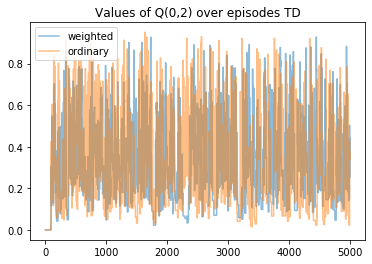

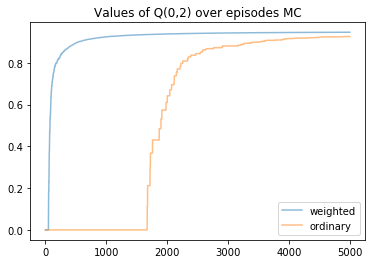

In [112]:
plot_variances(0,2)

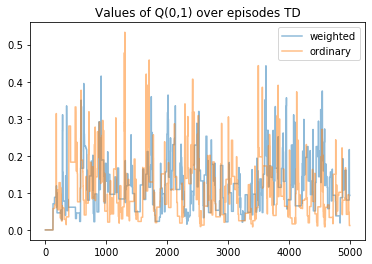

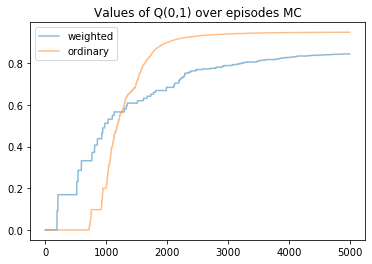

In [114]:
plot_variances(0,1)